In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
plt.rcParams['figure.figsize'] = (12,7)

# Checking the data files
import os
print(os.listdir("../input/cell-images-for-detecting-malaria/cell_images"))

['Uninfected', 'Parasitized', 'cell_images']


In [2]:
# Setting paths and showing the number of images
infected = os.listdir("../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized")
infected_path = "../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized"
print("Length of infected data = ", len(infected), 'images')
uninfected = os.listdir("../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected")
uninfected_path = "../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected"
print("Length of uninfected data = ", len(uninfected), 'images')

Length of infected data =  13780 images
Length of uninfected data =  13780 images


# Visualising the images

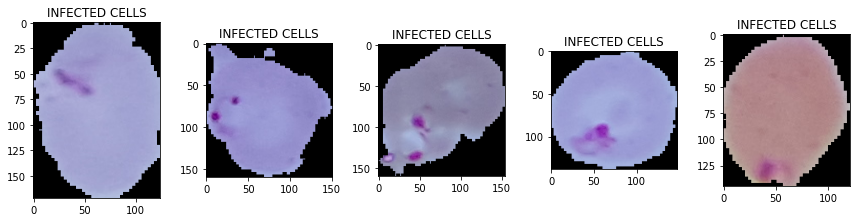

In [3]:
# Infected cells

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(infected_path + '/' + infected[i]))
    plt.title('INFECTED CELLS')
    plt.tight_layout()
plt.show()

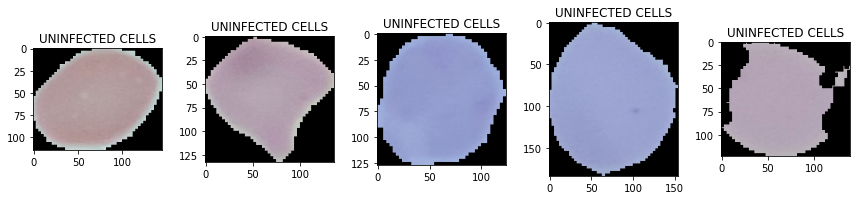

In [4]:
# Uninfected cells

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(uninfected_path + '/' + uninfected[i]))
    plt.title('UNINFECTED CELLS')
    plt.tight_layout()
plt.show()

# Deciding ideal dimensions to crop images to 

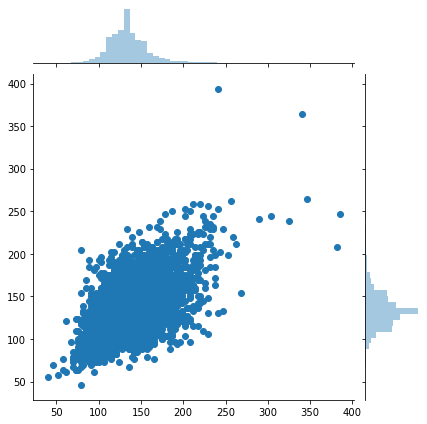

In [5]:
dim1 = []
dim2 = []
for file in infected:
    try:
        imag = imread(infected_path + '/' +file)
        d1,d2,colors = imag.shape
        dim1.append(d1)
        dim2.append(d2)
    except:
        None
        
sns.jointplot(dim1, dim2)

We can find out the mean of dimensions and take those

In [6]:
print('Mean of X dimensions - ',np.mean(dim1))
print('Mean of Y dimensions - ',np.mean(dim2))

Mean of X dimensions -  134.3868930981929
Mean of Y dimensions -  133.6318310472458


In [7]:
# Defining Image Data Gen

img_shape = (130, 130, 3)
image_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/225,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest',
                              validation_split=0.2)

Generating train and test splits of images

In [8]:
train = image_gen.flow_from_directory('../input/cell-images-for-detecting-malaria/cell_images/cell_images',
                                     target_size = img_shape[:2],
                                     color_mode = 'rgb',
                                     batch_size = 32,
                                     class_mode = 'binary',
                                     subset = 'training',
                                     shuffle = True)

validation = image_gen.flow_from_directory('../input/cell-images-for-detecting-malaria/cell_images/cell_images',
                                     target_size = img_shape[:2],
                                     color_mode ='rgb',
                                     batch_size = 32,
                                     class_mode = 'binary',
                                     subset = 'validation',
                                     shuffle = False)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [9]:
train.class_indices

{'Parasitized': 0, 'Uninfected': 1}

# Creating the CNN Model

In [10]:
model = Sequential()


model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape = (130,130,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [12]:
early = EarlyStopping(monitor='val_loss',patience=2,verbose=1)
model.metrics_names

[]

In [13]:
model.fit_generator(train,
                   epochs=20,
                   validation_data=validation,
                   callbacks=[early])

Epoch 1/20
689/689 [==============================] - 171s 248ms/step - loss: 0.4482 - accuracy: 0.7929 - val_loss: 0.2122 - val_accuracy: 0.9289
Epoch 2/20
689/689 [==============================] - 146s 211ms/step - loss: 0.2015 - accuracy: 0.9336 - val_loss: 0.1952 - val_accuracy: 0.9294
Epoch 3/20
689/689 [==============================] - 141s 204ms/step - loss: 0.1762 - accuracy: 0.9481 - val_loss: 0.1811 - val_accuracy: 0.9405
Epoch 4/20
689/689 [==============================] - 139s 202ms/step - loss: 0.1606 - accuracy: 0.9508 - val_loss: 0.1979 - val_accuracy: 0.9410
Epoch 5/20
689/689 [==============================] - 143s 208ms/step - loss: 0.1572 - accuracy: 0.9511 - val_loss: 0.1648 - val_accuracy: 0.9441
Epoch 6/20
689/689 [==============================] - 143s 208ms/step - loss: 0.1530 - accuracy: 0.9521 - val_loss: 0.1699 - val_accuracy: 0.9421
Epoch 7/20
689/689 [==============================] - 141s 204ms/step - loss: 0.1510 - accuracy: 0.9527 - val_loss: 0.1768 -

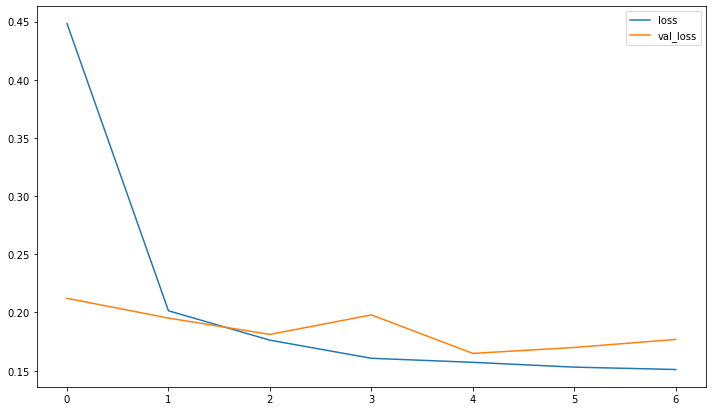

In [14]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

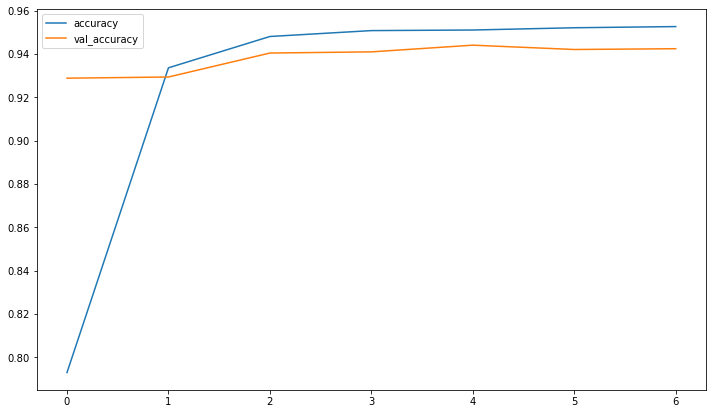

In [16]:
losses[['accuracy','val_accuracy']].plot()

In [17]:
predictions = model.predict_generator(validation)
predictions = predictions>0.5
print('Confusion Matrix: \n',confusion_matrix(validation.classes,predictions),'\n')
print('Classification Report: \n\n',classification_report(validation.classes,predictions))

Confusion Matrix: 
 [[2567  188]
 [ 104 2651]] 

Classification Report: 

               precision    recall  f1-score   support

           0       0.96      0.93      0.95      2755
           1       0.93      0.96      0.95      2755

    accuracy                           0.95      5510
   macro avg       0.95      0.95      0.95      5510
weighted avg       0.95      0.95      0.95      5510



In [ ]:
model.save('model.h5')